In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from my_functions import *
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

In [2]:
w_central = central_wavelength()

In [3]:
def identify_lines(line_Arr, qso_flx, nb_min=0):
    '''
    Returns a list of N lists with the index positions of the lines.

    Input: 
    line_Arr: Bool array of 3sigma detections in sources. Dim N_filters x N_sources
    qso_flx:  Flambda data
    nb_min
    '''
    N_fil, N_src = line_Arr.shape
    line_list = []

    for src in range(N_src):
        fil = 0
        this_src_lines = []
        while fil < N_fil:
            this_line = []
            while ~line_Arr[fil, src]:
                fil += 1
                if fil == N_fil - 1: break
            if fil == N_fil - 1: break
            while line_Arr[fil, src]:
                this_line.append(fil)
                fil += 1
                if fil == N_fil - 1: break
            if fil == N_fil - 1: break
            this_src_lines.append(
                fil + np.argmax(qso_flx[np.array(this_line) + nb_min, src])\
                - len(this_line) + nb_min
            )
        line_list.append(this_src_lines)
    return line_list

In [4]:
## Load QSO catalog
filename = ('/home/alberto/cosmos/JPAS_mocks_sep2021/'
    'JPAS_mocks_classification_01sep_model11/Fluxes/Qso_jpas_mock_flam_train.cat')

my_filter_order = np.arange(60)
my_filter_order[[-4, -3, -2, -1]] = np.array([1, 12, 28, 43])
my_filter_order[1:-4] += 1
my_filter_order[12:-4] += 1
my_filter_order[28:-4] += 1
my_filter_order[43:-4] += 1

qso_flx = pd.read_csv(
    filename, sep=' ', usecols=range(2, 2 + 60)
).to_numpy().T[my_filter_order]
qso_err = pd.read_csv(
    filename, sep=' ', usecols=range(2 + 60, 2 + 60 + 60)
).to_numpy().T[my_filter_order]
zspec = pd.read_csv(filename, sep=' ', usecols=[127]).to_numpy().reshape(-1, )

In [5]:
N_sources = qso_flx.shape[1]
N_nb = 6
ew0min = 20

In [6]:
fwhm_Arr = []
for i in range(60):
    fwhm_Arr.append(nb_fwhm(i))

In [7]:
nb_c_min = 6
nb_c_max = 50
line_qso = np.zeros((nb_c_max - nb_c_min, N_sources)).astype(bool)
line_qso_ew0 = np.zeros((nb_c_max - nb_c_min, N_sources)).astype(bool)
cont_est_Arr = np.zeros((nb_c_max - nb_c_min, N_sources))
cont_err_Arr = np.zeros((nb_c_max - nb_c_min, N_sources))
i = 0
for nb_c in range(nb_c_min, nb_c_max):
    z_nb = w_central[nb_c] / 1215.67 - 1
    fwhm = fwhm_Arr[nb_c]
    cont_est_qso, cont_err_qso = stack_estimation(qso_flx, qso_err, nb_c, N_nb, False)
    line_qso_ew0[i] = (
        (qso_flx[nb_c] - cont_est_qso > 3 * (cont_err_qso**2 + qso_err[nb_c]**2) ** 0.5)
        & (qso_flx[nb_c] - cont_est_qso > ew0min * (1 + z_nb) * cont_est_qso / fwhm)
    )
    cont_est_Arr[i] = cont_est_qso
    cont_err_Arr[i] = cont_err_qso
    i += 1

line_list_ew0 = identify_lines(line_qso_ew0, qso_flx, nb_c_min)

In [8]:
z_nb_Arr = np.ones(N_sources) * 999
ew0min_2 = 15

for src in range(N_sources):
    try:
        l_lya = line_list_ew0[src][0]
    except:
        continue
    z_nb_Arr[src] = w_central[l_lya] / 1215.67 - 1

i = 0
for nb_c in range(nb_c_min, nb_c_max):
    fwhm = fwhm_Arr[nb_c]
    cont_est_qso, cont_err_qso = stack_estimation(qso_flx, qso_err, nb_c, N_nb, False)
    line_qso[i] = (
        (qso_flx[nb_c] - cont_est_qso > 3 * (cont_err_qso**2 + qso_err[nb_c]**2) ** 0.5)
        & (qso_flx[nb_c] - cont_est_qso > ew0min_2 * (1 + z_nb_Arr) * cont_est_qso / fwhm)
    )
    i += 1

line_list = identify_lines(line_qso, qso_flx, nb_c_min)

In [9]:
w_lya = 1215.67
w_SiIV = 1397.61
w_CIV = 1549.48
w_CIII = 1908.73
w_MgII = 2799.12

In [10]:
no_line = 0
single_line = 0
single_right_z = 0
multiple_lines = 0
right_z = 0
nice_lya = 0
nice_lya_z = 0
nice_lya_Arr = []
nice_lya_z_Arr = []
for src in range(N_sources):
    try:
        l_lya = line_list_ew0[src][0]
        w_obs_lya = w_central[l_lya]
    except:
        no_line += 1
        continue # No lines here

    if zspec[src] > 2.55:
        right_z += 1
        if len(line_list[src]) <= 1:
            single_right_z += 1

    if (len(line_list[src]) <= 1):
        single_line += 1
        continue # Just one line here

    multiple_lines += 1

    z_src = w_obs_lya / w_lya - 1

    w_obs_SiIV = (1 + z_src) * w_SiIV
    w_obs_CIV = (1 + z_src) * w_CIV
    w_obs_CIII = (1 + z_src) * w_CIII
    w_obs_MgII = (1 + z_src) * w_MgII

    is_nice_lya = True
    if line_list[src][0] > 27: # Mock zspec max is 4.3
        is_nice_lya = False

    lya_flx = qso_flx[l_lya, src]

    fwhm = fwhm_Arr[l_lya]

    for l in line_list[src]:
        w_obs_l = w_central[l]
        if ~(   
                # Lines are in expected possitions for QSOs
                (
                (np.abs(w_obs_l - w_obs_lya) < fwhm / 2)
                | (np.abs(w_obs_l - w_obs_SiIV) < fwhm / 2)
                | (np.abs(w_obs_l - w_obs_CIV) < fwhm / 2)
                | (np.abs(w_obs_l - w_obs_CIII) < fwhm / 2)
                | (np.abs(w_obs_l - w_obs_MgII) < fwhm / 2)
                | (w_obs_l > w_obs_MgII + fwhm / 2)
                )
                # The Lya line flux is the highest
                & (qso_flx[l, src] - cont_est_Arr[l - nb_c_min, src]
                    <= lya_flx - cont_est_Arr[l_lya - nb_c_min, src])
                # g > r
                & (qso_flx[-3, src] > qso_flx[-2, src])
                # Cannot be other lines bluer than lya
                & (l >= l_lya)
            ):
            is_nice_lya = False
    if is_nice_lya:
        nice_lya += 1
        nice_lya_Arr.append(src)
    if is_nice_lya & (zspec[src] > 2.5):
        nice_lya_z += 1
        nice_lya_z_Arr.append(src)

print('N_sources      = {}'.format(N_sources))
print('total_detec    = {}'.format(N_sources - no_line))
print('right_z        = {}'.format(right_z))
print('single_line    = {}'.format(single_line))
print('single_right_z = {}'.format(single_right_z))
print('multiple_line  = {}'.format(multiple_lines))
print('nice_lya       = {}'.format(nice_lya))
print('nice_lya_z     = {}'.format(nice_lya_z))

N_sources      = 100000
total_detec    = 62533
right_z        = 10884
single_line    = 30614
single_right_z = 4102
multiple_line  = 31919
nice_lya       = 2402
nice_lya_z     = 1044


In [11]:
len(np.where(z_nb_Arr < 990)[0])

62533

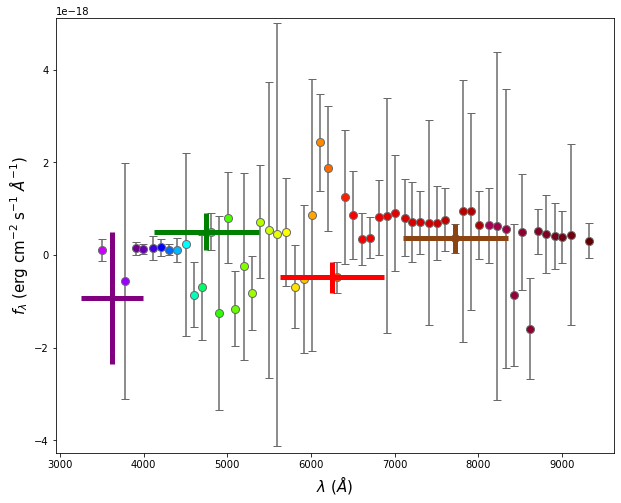

z_spec = 4.0471
z_nb   = 999.0


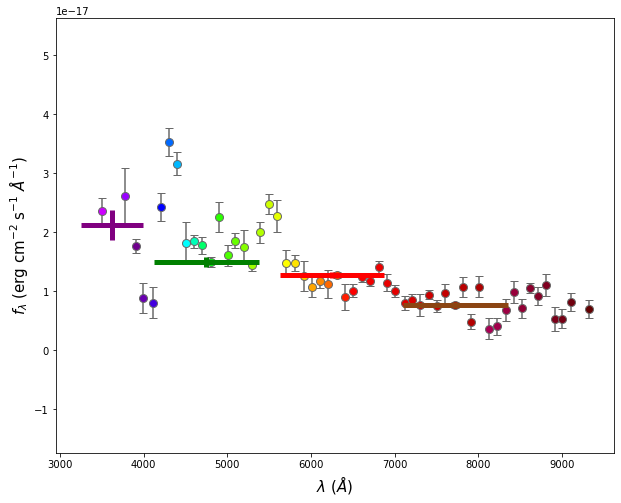

z_spec = 2.5578
z_nb   = 2.539611901256097


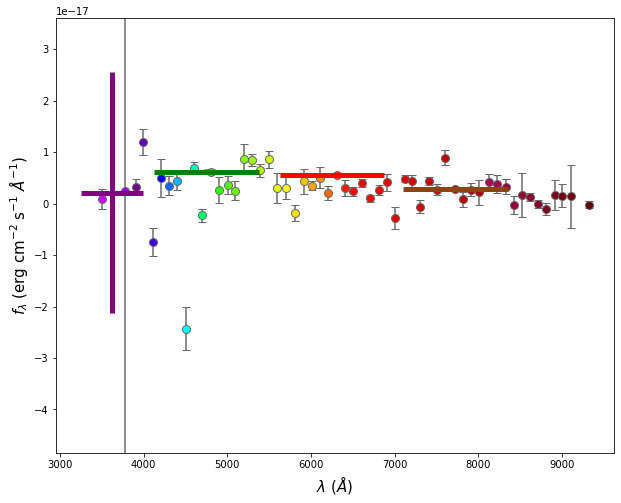

z_spec = 3.2999
z_nb   = 4.189730765750573


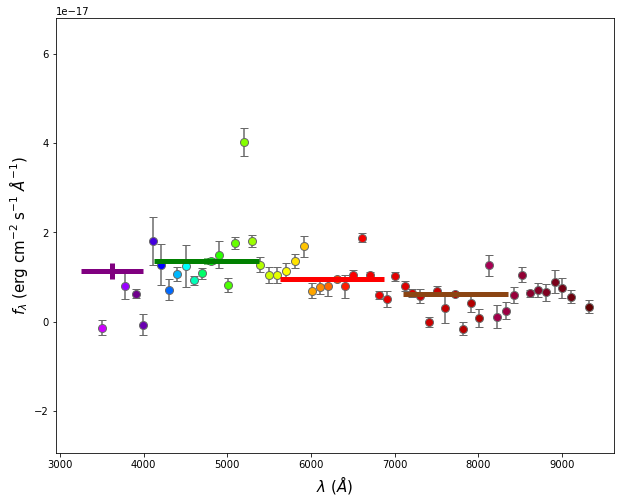

z_spec = 3.2778
z_nb   = 3.279121801146693


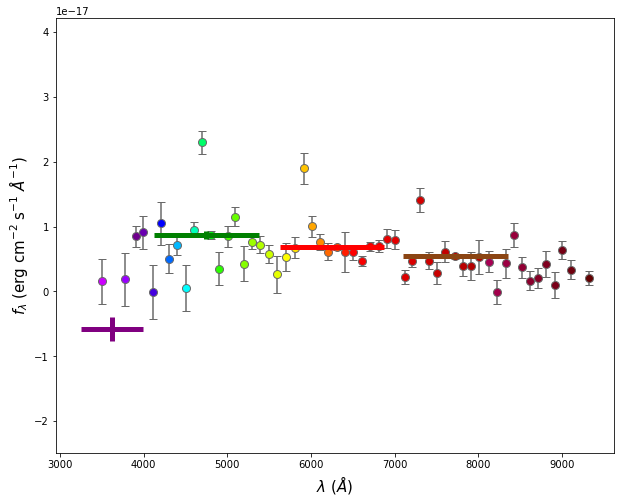

z_spec = 2.8848
z_nb   = 2.867003380851711


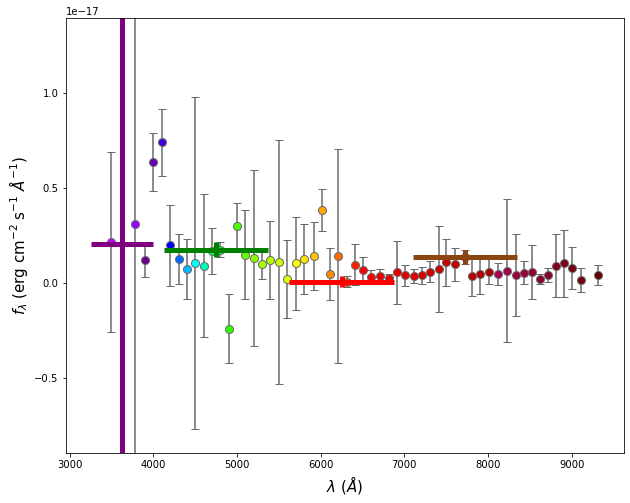

z_spec = 2.9289
z_nb   = 3.943775860225225


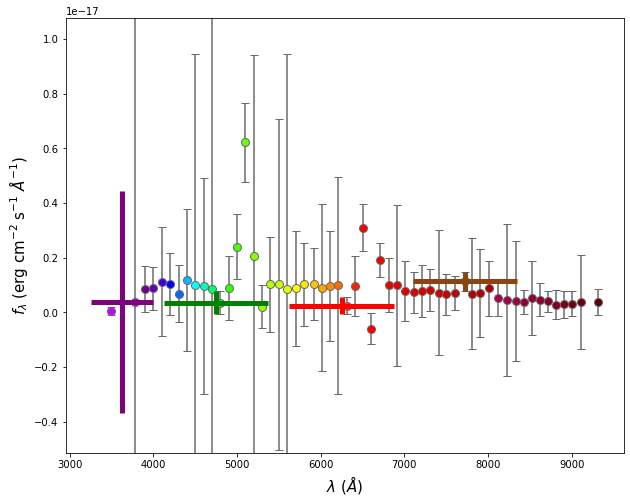

z_spec = 3.186
z_nb   = 3.192749677132774


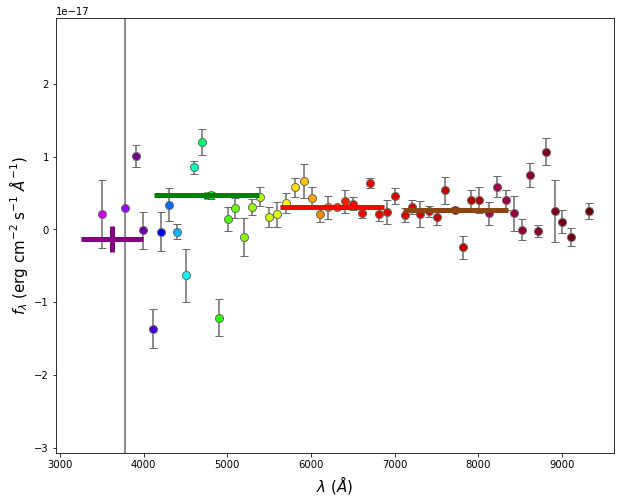

z_spec = 2.8259
z_nb   = 2.867003380851711


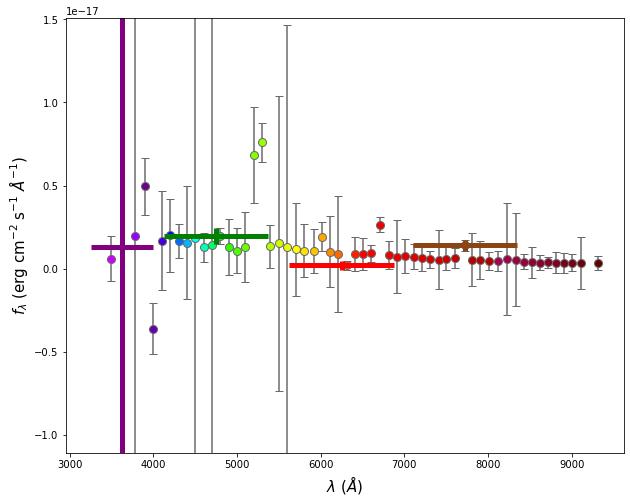

z_spec = 3.3344
z_nb   = 3.3564454169305815


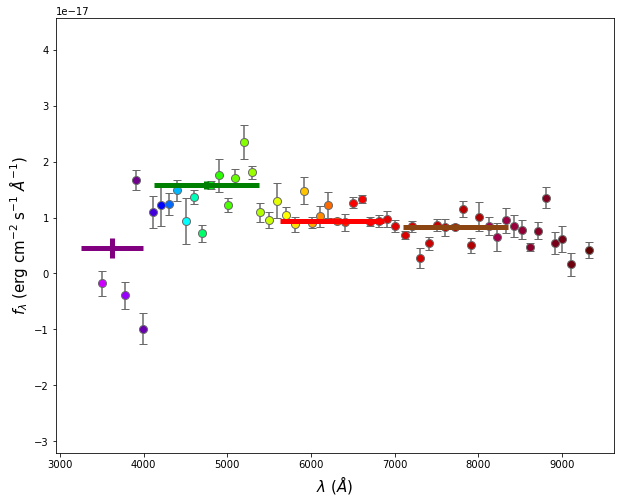

z_spec = 3.2554
z_nb   = 3.279121801146693


In [12]:
for src in np.random.choice(np.where(zspec > 2.5)[0], 10):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = plot_JPAS_source(qso_flx[:, src], qso_err[:, src])
    
    plt.show()
    print('z_spec = {}'.format(zspec[src]))
    print('z_nb   = {}'.format(z_nb_Arr[src]))

In [13]:
nice_lya_Arr, nice_lya_Arr_single, line_list_lya, line_list_other =\
     QSO_find_lines(qso_flx, qso_err, nb_c_min, nb_c_max, 30, 15, 6)

Lya list done. (15.8 s)
Other lines list done. (6.4 s)
Nice Lya list done. (6.4 )


In [14]:
print('QSO candidates found : {}'.format(len(nice_lya_Arr)))
print('QSO candidates single: {}'.format(len(nice_lya_Arr_single)))

QSO candidates found : 2508
QSO candidates single: 53937


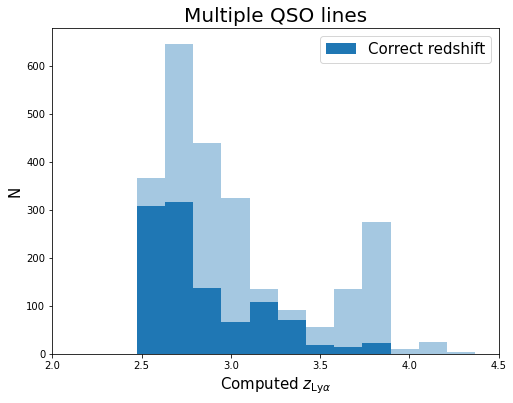

/tmp/ipykernel_1161285/1807059121.py:29: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter(bin_centers, h_detec_r / h_detec, label='Correct z')


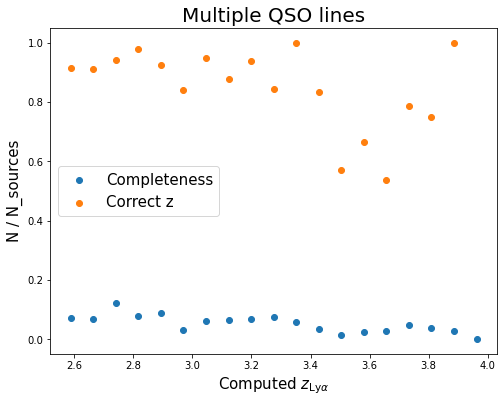

In [15]:
nice_lya_Arr_bool = np.zeros(N_sources).astype(bool)
nice_lya_Arr_bool[nice_lya_Arr] = True

fig, ax = plt.subplots(figsize=(8, 6))
bins = np.linspace(2, 5, 20)
#ax.hist(zspec, bins=bins, label='All', histtype='step')
ax.hist(z_nb_Arr[nice_lya_Arr_bool], bins=bins,
    alpha=0.4, color='C0')
ax.hist(z_nb_Arr[nice_lya_Arr_bool & (np.abs(zspec - z_nb_Arr) < 0.1)], bins=bins,
    label='Correct redshift', color='C0')
ax.set_ylabel('N', fontsize=15)
ax.set_xlabel(r'Computed $z_{\mathrm{Ly}\alpha}$', fontsize=15)
ax.legend(fontsize=15)
ax.set_title('Multiple QSO lines', fontsize=20)
ax.set_xlim((2, 4.5))
plt.show()

## Completeness
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.linspace(2.55, 4, 20)
h_zspec, b = np.histogram(zspec[zspec > 2.5], bins=bins)
h_detec, _ = np.histogram(zspec[nice_lya_Arr_bool], bins=bins)
h_detec_r, _ = np.histogram(zspec[nice_lya_Arr_bool & (np.abs(zspec - z_nb_Arr) < 0.1)],
    bins=bins)

bin_centers = [(b[i + 1] + b[i]) / 2 for i in range(len(b) - 1)]
ax.scatter(bin_centers, h_detec_r / h_zspec, label='Completeness')
ax.scatter(bin_centers, h_detec_r / h_detec, label='Correct z')
ax.set_xlabel(r'Computed $z_{\mathrm{Ly}\alpha}$', fontsize=15)
ax.set_ylabel('N / N_sources', fontsize=15)
ax.legend(fontsize=15, loc=6)
ax.set_title('Multiple QSO lines', fontsize=20)
plt.show()

/home/alberto/cosmos/LAEs/my_functions.py:19: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f * w**2/c * 1e-8) - 48.60
/home/alberto/cosmos/LAEs/my_functions.py:19: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f * w**2/c * 1e-8) - 48.60
/home/alberto/cosmos/LAEs/my_functions.py:19: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f * w**2/c * 1e-8) - 48.60


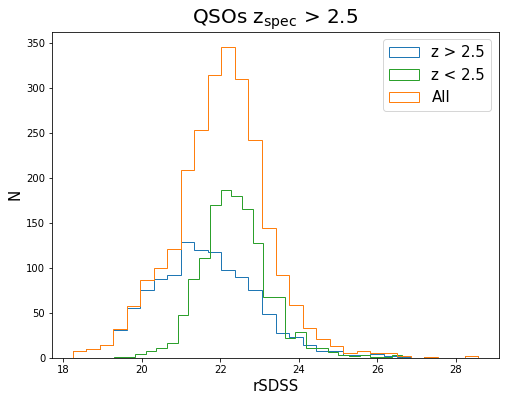

/home/alberto/cosmos/LAEs/my_functions.py:19: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f * w**2/c * 1e-8) - 48.60


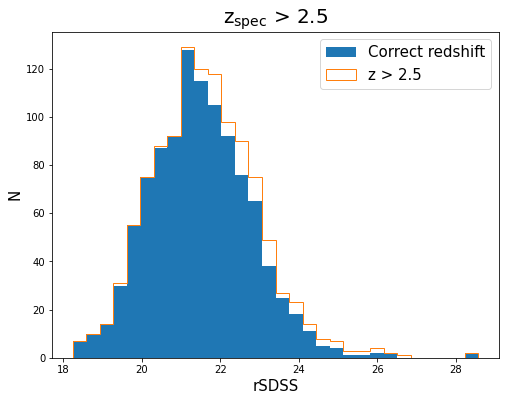

/home/alberto/cosmos/LAEs/my_functions.py:19: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f * w**2/c * 1e-8) - 48.60


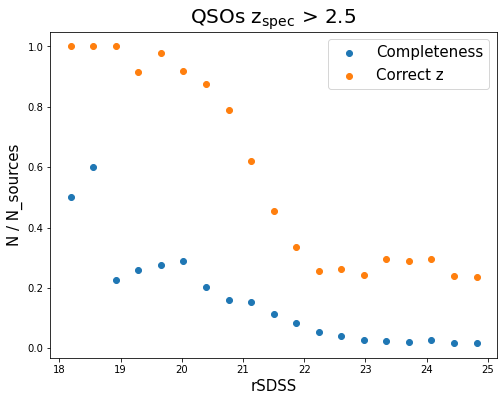

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
bins = 30
#ax.hist(zspec, bins=bins, label='All', histtype='step')
ax.hist(flux_to_mag(qso_flx[-2, np.where(nice_lya_Arr_bool & (zspec > 2.5))[0]], w_central[-2]),
    bins=bins,
    color='C0', label='z > 2.5', histtype='step')
ax.hist(flux_to_mag(qso_flx[-2, np.where(nice_lya_Arr_bool & (zspec < 2.5))[0]], w_central[-2]),
    bins=bins,
    color='C2', label='z < 2.5', histtype='step')
ax.hist(flux_to_mag(qso_flx[-2, np.where(nice_lya_Arr_bool)[0]], w_central[-2]),
    bins=bins,
    color='C1', label='All', histtype='step')
ax.set_ylabel('N', fontsize=15)
ax.set_xlabel('rSDSS', fontsize=15)
ax.legend(fontsize=15)
ax.set_title('QSOs z$_\mathrm{spec}$ > 2.5', fontsize=20)
plt.show()


fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(flux_to_mag(qso_flx[-2, np.where(nice_lya_Arr_bool & (np.abs(zspec - z_nb_Arr) < 0.1))[0]],
    w_central[-2]), bins=bins,
    label='Correct redshift')
ax.hist(flux_to_mag(qso_flx[-2, np.where(nice_lya_Arr_bool & (zspec > 2.5))[0]], w_central[-2]),
    bins=bins, label='z > 2.5', histtype='step')
ax.set_ylabel('N', fontsize=15)
ax.set_xlabel('rSDSS', fontsize=15)
ax.legend(fontsize=15)
ax.set_title('z$_\mathrm{spec}$ > 2.5', fontsize=20)
plt.show()


## Completeness
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.linspace(18, 25, 20)
h_r, b = np.histogram(flux_to_mag(qso_flx[-2, zspec > 2.5],
    w_central[-2]), bins=bins)
h_detec, _ = np.histogram(flux_to_mag(
    qso_flx[-2, nice_lya_Arr_bool], w_central[-2]),
    bins=bins)
h_detec_r, _ = np.histogram(flux_to_mag(
    qso_flx[-2, nice_lya_Arr_bool & (np.abs(zspec - z_nb_Arr) < 0.1)], w_central[-2]),
    bins=bins)

bin_centers = [(b[i + 1] + b[i]) / 2 for i in range(len(b) - 1)]
ax.scatter(bin_centers, h_detec_r / h_r, label='Completeness')
ax.scatter(bin_centers, h_detec_r / h_detec, label='Correct z')
ax.set_xlabel('rSDSS', fontsize=15)
ax.set_ylabel('N / N_sources', fontsize=15)
ax.legend(fontsize=15)
ax.set_title('QSOs z$_\mathrm{spec}$ > 2.5', fontsize=20)
plt.show()

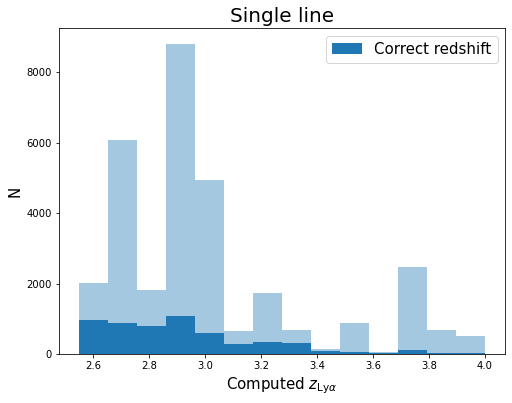

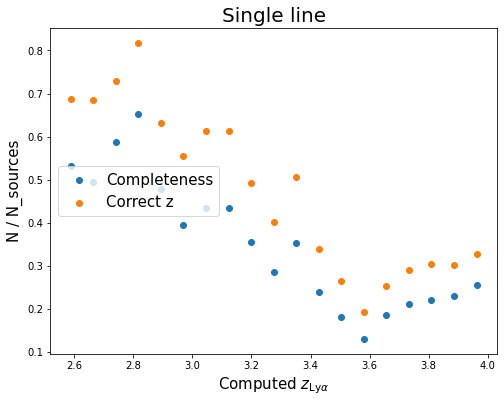

In [17]:
nice_lya_Arr_single_bool = np.zeros(N_sources).astype(bool)
nice_lya_Arr_single_bool[nice_lya_Arr_single] = True

fig, ax = plt.subplots(figsize=(8, 6))
bins = np.linspace(2.55, 4, 15)
#ax.hist(zspec, bins=bins, label='All', histtype='step')
ax.hist(z_nb_Arr[np.where(nice_lya_Arr_single_bool)], bins=bins,
    alpha=0.4, color='C0')
ax.hist(z_nb_Arr[np.where(nice_lya_Arr_single_bool & (np.abs(zspec - z_nb_Arr) < 0.1))],
    bins=bins, label='Correct redshift', color='C0')
ax.set_ylabel('N', fontsize=15)
ax.set_xlabel(r'Computed $z_{\mathrm{Ly}\alpha}$', fontsize=15)
ax.legend(fontsize=15)
ax.set_title('Single line', fontsize=20)
plt.show()

## Completeness
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.linspace(2.55, 4, 20)
h_zspec, b = np.histogram(zspec[zspec > 2.5], bins=bins)
h_detec, _ = np.histogram(zspec[nice_lya_Arr_single_bool], bins=bins)
h_detec_r, _ = np.histogram(zspec[nice_lya_Arr_single_bool & (np.abs(zspec - z_nb_Arr) < 0.1)],
    bins=bins)

bin_centers = [(b[i + 1] + b[i]) / 2 for i in range(len(b) - 1)]
ax.scatter(bin_centers, h_detec_r / h_zspec, label='Completeness')
ax.scatter(bin_centers, h_detec_r / h_detec, label='Correct z')
ax.set_xlabel(r'Computed $z_{\mathrm{Ly}\alpha}$', fontsize=15)
ax.set_ylabel('N / N_sources', fontsize=15)
ax.legend(fontsize=15, loc=6)
ax.set_title('Single line', fontsize=20)
plt.show()

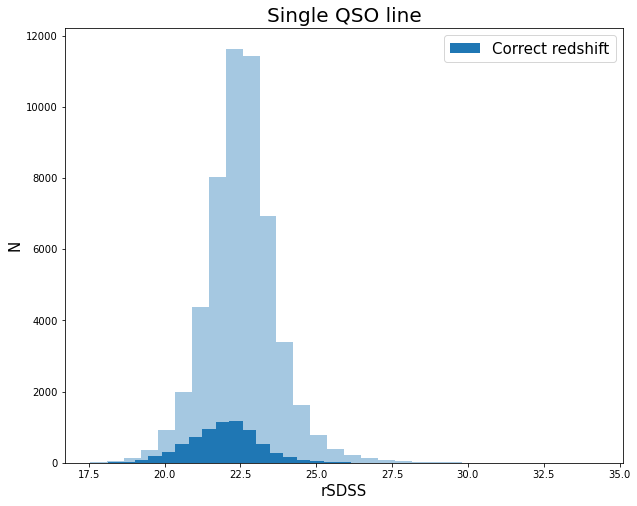

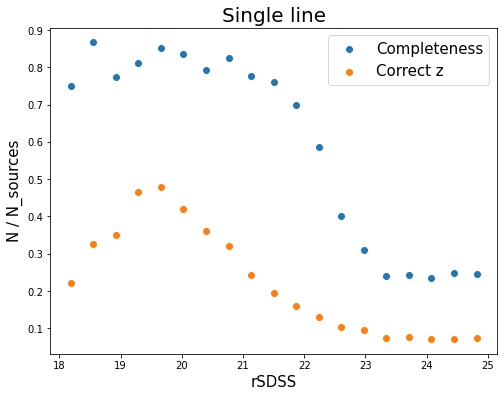

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
bins = 30
#ax.hist(zspec, bins=bins, label='All', histtype='step')
ax.hist(flux_to_mag(qso_flx[-2, np.where(nice_lya_Arr_single_bool)[0]], w_central[-2]),
    bins=bins,
    alpha=0.4, color='C0')
ax.hist(flux_to_mag(qso_flx[-2, np.where(nice_lya_Arr_single_bool & (np.abs(zspec - z_nb_Arr) < 0.1))[0]],
    w_central[-2]), bins=bins,
    label='Correct redshift', color='C0')
ax.set_ylabel('N', fontsize=15)
ax.set_xlabel('rSDSS', fontsize=15)
ax.legend(fontsize=15)
ax.set_title('Single QSO line', fontsize=20)
plt.show()

## Completeness
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.linspace(18, 25, 20)
h_r, b = np.histogram(flux_to_mag(qso_flx[-2, zspec > 2.5],
    w_central[-2]), bins=bins)
h_detec, _ = np.histogram(flux_to_mag(
    qso_flx[-2, nice_lya_Arr_single_bool], w_central[-2]),
    bins=bins)
h_detec_r, _ = np.histogram(flux_to_mag(
    qso_flx[-2, nice_lya_Arr_single_bool & (np.abs(zspec - z_nb_Arr) < 0.1)], w_central[-2]),
    bins=bins)

bin_centers = [(b[i + 1] + b[i]) / 2 for i in range(len(b) - 1)]
ax.scatter(bin_centers, h_detec_r / h_r, label='Completeness')
ax.scatter(bin_centers, h_detec_r / h_detec, label='Correct z')
ax.set_xlabel('rSDSS', fontsize=15)
ax.set_ylabel('N / N_sources', fontsize=15)
ax.legend(fontsize=15)
ax.set_title('Single line', fontsize=20)
plt.show()